In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sys.path.insert(0, '../')
import numpy as np
import scipy as sp
import cv2
import keras
import datetime
from tqdm import tqdm
from glob2 import glob

Using TensorFlow backend.


In [3]:
from common.utils import *
from common.nn import *
from common.eval import *
import common

In [4]:
resolutions = [(64*i,192*i) for i in range(1,5)][::-1]

In [5]:
n_rows,n_cols = resolutions[0]
im_shape = (n_rows,n_cols)
n_channels = 3
input_shape = (n_rows,n_cols,n_channels)

In [6]:
boundary_only =  False

In [7]:
net = get_custom_unet(input_shape=input_shape,n_conv=8,act='relu',bottle_idx=5)
        
history = []

In [8]:
DATA_ROOT = '/storage/cvlab/RDC/'
TRAIN_DIR = DATA_ROOT+'unity/simple_road_dataset/'
im_paths = np.array(glob(TRAIN_DIR +  '*img.png'))
masks_paths = np.array(glob(TRAIN_DIR +  '*layer.png'))
kia_idx = in_filename(im_paths)
kia_match = np.ones(len(im_paths), dtype=bool)
kia_match[kia_idx] = False
kia_im_paths = im_paths[kia_idx]
kia_mask_paths = masks_paths[kia_idx]
im_paths = im_paths[kia_match]
masks_paths = masks_paths[kia_match]

In [9]:
def binarize_mask(m_):
    m = m_.copy()
    con = np.logical_and(m > 0, m < 255)
    m[con] = 1
    m[~con] = 0
    return m

In [10]:
im_paths_train, im_paths_val, masks_paths_train,masks_paths_val = train_test_split(sorted(im_paths), sorted(masks_paths),
                                                                                   random_state=42,test_size=0.1)

In [11]:
X_train = np.array([imread_and_resize(e,im_shape,n_channels == 3) for e in tqdm(im_paths_train)])
y_train = np.array([imread_and_resize(e,im_shape,False) for e in tqdm(masks_paths_train)])
X_val = np.array([imread_and_resize(e,im_shape,n_channels == 3) for e in tqdm(im_paths_val)])
y_val = np.array([imread_and_resize(e,im_shape,False) for e in tqdm(masks_paths_val)])
y_train,y_val = binarize_mask(y_train),binarize_mask(y_val)

if boundary_only:
    y_train = np.array([boundary_mask(e) for e in y_train])
    y_val = np.array([boundary_mask(e) for e in y_val])

100%|██████████| 5/5 [00:00<00:00, 181.13it/s]


In [44]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

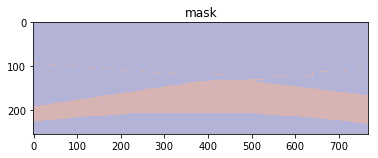

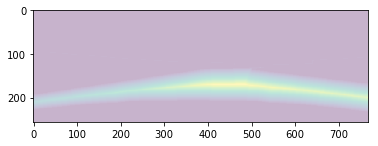

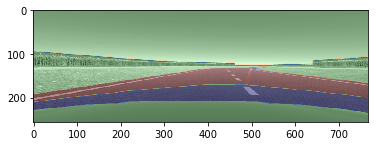

In [47]:
k = 2
im = cv2.cvtColor(X_train[k],cv2.COLOR_BGR2GRAY)
mask = y_train[k]

edt = sp.ndimage.morphology.distance_transform_bf(mask)
grad = np.gradient(edt,1)
#imshow(im,cmap='gray')
title('mask')
imshow(mask,cmap='jet',alpha=0.3)
show()
#imshow(im,cmap='gray')
imshow(edt,alpha=0.3)
show()
imshow(im,cmap='gray')
imshow(grad[0],alpha=0.3,cmap='jet')

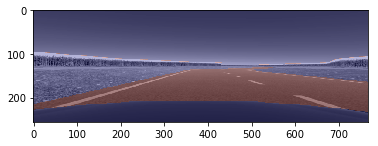

In [12]:
imshow(X_train[1][...,-1],cmap='gray')
imshow(y_train[1],cmap='jet',alpha=0.3)

In [13]:
do_parallel = False

In [14]:

losses=[dice_crossentopy_loss]
metrics = [f1_score,dice_coef]
net.compile(optimizer=keras.optimizers.Adam(lr=0.0002),
                  loss = losses,metrics=metrics)
history.append(net.fit(X_train,expand(y_train),validation_data=(X_val,expand(y_val)),
    epochs=50,
    initial_epoch=0,
    batch_size=2,
    verbose=1
))

Train on 44 samples, validate on 5 samples
Epoch 1/50
44/44 [==============================] - 8s 190ms/step - loss: 5.1529 - f1_score: 0.2747 - dice_coef: 0.2605 - val_loss: 2.9079 - val_f1_score: 0.4528 - val_dice_coef: 0.4272
Epoch 2/50
44/44 [==============================] - 3s 75ms/step - loss: 2.2575 - f1_score: 0.6692 - dice_coef: 0.5648 - val_loss: 1.4834 - val_f1_score: 0.8839 - val_dice_coef: 0.8201
Epoch 3/50
44/44 [==============================] - 3s 75ms/step - loss: 1.3032 - f1_score: 0.9309 - dice_coef: 0.8911 - val_loss: 1.2336 - val_f1_score: 0.9398 - val_dice_coef: 0.9272
Epoch 4/50
44/44 [==============================] - 3s 75ms/step - loss: 1.1515 - f1_score: 0.9581 - dice_coef: 0.9497 - val_loss: 1.1271 - val_f1_score: 0.9595 - val_dice_coef: 0.9551
Epoch 5/50
44/44 [==============================] - 3s 75ms/step - loss: 1.0939 - f1_score: 0.9689 - dice_coef: 0.9628 - val_loss: 1.1053 - val_f1_score: 0.9654 - val_dice_coef: 0.9625
Epoch 6/50
44/44 [=============

Epoch 45/50
44/44 [==============================] - 3s 75ms/step - loss: 1.0117 - f1_score: 0.9955 - dice_coef: 0.9941 - val_loss: 1.0150 - val_f1_score: 0.9938 - val_dice_coef: 0.9928
Epoch 46/50
44/44 [==============================] - 3s 75ms/step - loss: 1.0120 - f1_score: 0.9954 - dice_coef: 0.9940 - val_loss: 1.0128 - val_f1_score: 0.9949 - val_dice_coef: 0.9936
Epoch 47/50
44/44 [==============================] - 3s 76ms/step - loss: 1.0120 - f1_score: 0.9953 - dice_coef: 0.9940 - val_loss: 1.0125 - val_f1_score: 0.9954 - val_dice_coef: 0.9937
Epoch 48/50
44/44 [==============================] - 5s 118ms/step - loss: 1.0115 - f1_score: 0.9956 - dice_coef: 0.9942 - val_loss: 1.0121 - val_f1_score: 0.9955 - val_dice_coef: 0.9940
Epoch 49/50
44/44 [==============================] - 3s 75ms/step - loss: 1.0109 - f1_score: 0.9960 - dice_coef: 0.9945 - val_loss: 1.0118 - val_f1_score: 0.9956 - val_dice_coef: 0.9940
Epoch 50/50
44/44 [==============================] - 3s 75ms/step - l

## Validation

In [23]:
pred_probs = net.predict(X_val,batch_size=16,verbose=1)

5/5 [==============================] - 0s 19ms/step


In [24]:
evl = net.evaluate(X_val,expand(y_val),batch_size=16,verbose=1)

5/5 [==============================] - 0s 20ms/step


In [29]:
evl

[1.0118618011474609, 0.99544674158096313, 0.99409252405166626]

In [25]:
pred_probs = squeeze(pred_probs)

In [26]:
masks_pred = (pred_probs > 0.5).astype('uint8')

In [27]:
ridx = np.random.permutation(len(X_val))

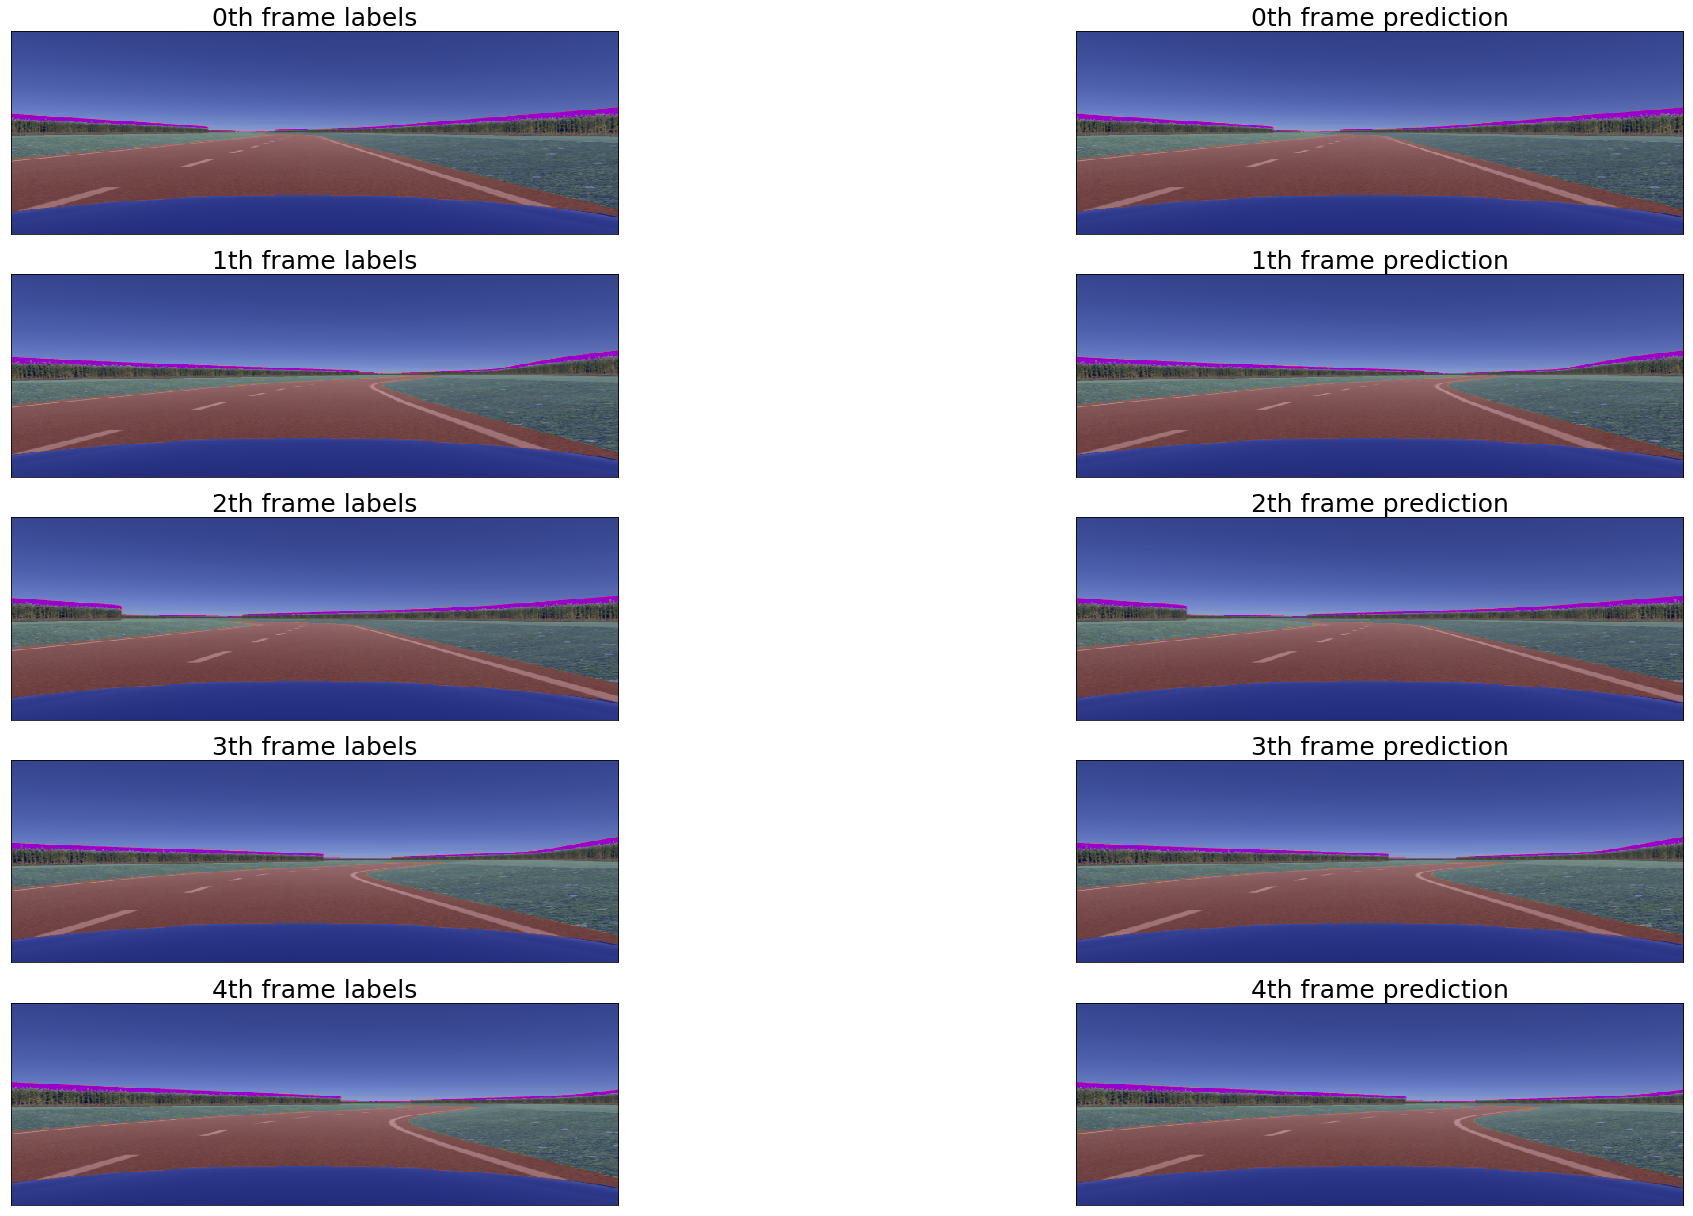

In [28]:
figure(facecolor='white')
plt.figure(figsize=(35,35),facecolor='white')
k = 0
for fr_idx in range(10):
    j = ridx[k]
    plt.subplot(8, 2, fr_idx+1,facecolor='white')
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)
    if fr_idx % 2 == 0:
        title('%sth frame labels' % k,fontsize=25)
        imshow(X_val[j][...,::-1])
        imshow(y_val[j],cmap='jet',alpha=0.4)
    else:
        title('%sth frame prediction' % k,fontsize=25)
        imshow(X_val[j][...,::-1])
        imshow(masks_pred[j],cmap='jet',alpha=0.4)
        k += 1

In [21]:
assert

SyntaxError: invalid syntax (<ipython-input-21-7974e7ad4633>, line 1)

In [30]:
now = '{0:%Y-%m-%d_%H:%M:%S}'.format(datetime.datetime.now())

In [31]:
model_path = ('../../rdc-experiments/unet-unity_f1:%.2f_dice:%.2f_%s.h5' % (evl[1], evl[2],now))

In [32]:
net.save(model_path)

In [33]:
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 768, 3)  0                                            
__________________________________________________________________________________________________
conv_11 (Conv2D)                (None, 256, 768, 8)  224         input[0][0]                      
__________________________________________________________________________________________________
conv_12 (Conv2D)                (None, 256, 768, 8)  584         conv_11[0][0]                    
__________________________________________________________________________________________________
maxpool_1 (MaxPooling2D)        (None, 128, 384, 8)  0           conv_12[0][0]                    
__________________________________________________________________________________________________
conv_21 (C